In [9]:
!pip install torch-geometric
!pip install umap-learn
!pip3 install torch

/bin/bash: line 1: conda: command not found


In [35]:
# Dataset

import torch as nn

import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]



In [15]:
print(dir(dataset))

['__abstractmethods__', '__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_data', '_data_list', '_download', '_indices', '_infer_num_classes', '_is_protocol', '_process', 'collate', 'copy', 'data', 'download', 'geom_gcn_url', 'get', 'get_summary', 'has_download', 'has_process', 'index_select', 'indices', 'len', 'load', 'log', 'name', 'num_classes', 'num_edge_features', 'num_features', 'num_node_features', 'pre_filter', 'pre_transform', 'print_summary', 'process', 'processed_dir', 'processed_file_names', 'processed_paths', 'raw_dir', 'raw_file_na

In [18]:
print("len", len(dataset))
print("num of classes", dataset.num_classes)
print("num of edge", dataset.num_edge_features)
print("num node features", dataset.num_node_features)

len 1
num of classes 7
num of edge 0
num node features 1433


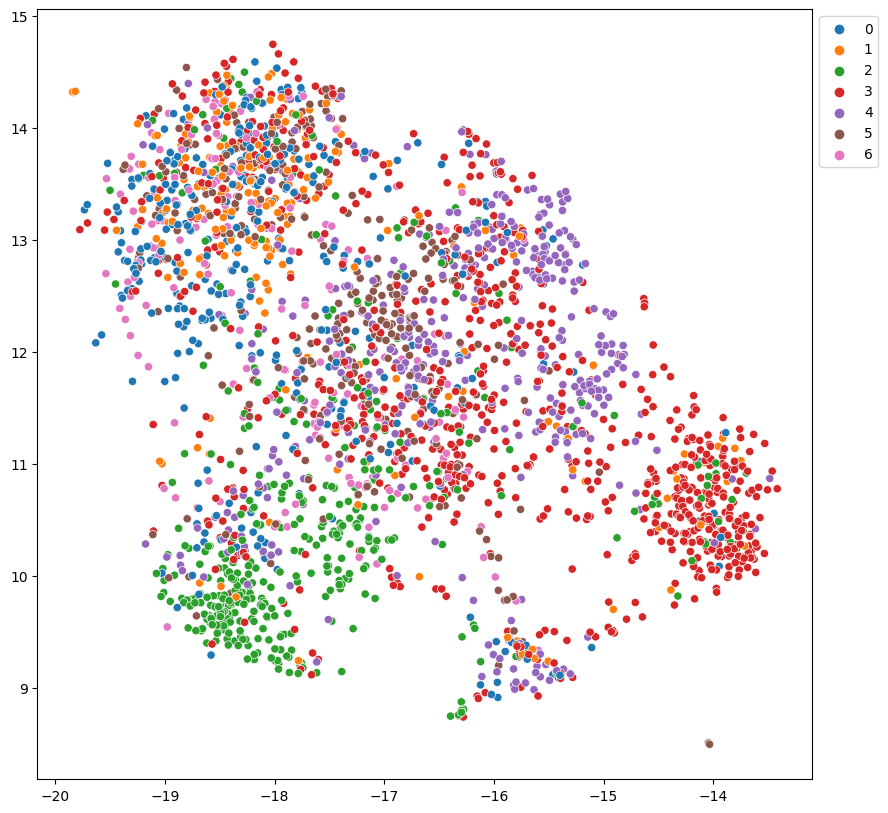

In [24]:
import umap.umap_ as umap
data_color = []

for y in data.y.numpy():
    data_color.append(f'C{y}')
embd = umap.UMAP().fit_transform(data.x.numpy())

palette = {}
for n, y in enumerate(set(data.y.numpy())):
    palette[y] = f'C{n}'

plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_raw.png", dpi=120)

In [23]:
import torch.nn as nn
import torch
# GCNConv
class GCNConv(nn.Module):
    def __init__(self, input_dimension, output_dimension):
        super(GCNConv, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dimension, output_dimension))
        self.bias = nn.Parameter(torch.Tensor(output_dimension))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, edge_index):
        adj_matrix = self.normalize_adjacency(edge_index, x.size(0))
        x = torch.matmul(adj_matrix, x) @ self.weight
        x = x + self.bias
        return x

    def normalize_adjacency(self, edge_index, num_nodes):
        row, col = edge_index
        deg = torch.zeros(num_nodes, dtype=torch.float)
        deg[row] += 1
        deg[col] += 1

        deg_inv_sqrt = 1 / torch.sqrt(deg.clamp(min=1))

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        adj_matrix = torch.sparse_coo_tensor(edge_index, norm, (num_nodes, num_nodes))
        return adj_matrix.to_dense()

# GCN 2-layer
class GCN(nn.Module):

  def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16) # num_features -> 16
        self.conv2 = GCNConv(16, 16)       # 16 -> 16
        self.fc1 = nn.Linear(16, dataset.num_classes)    # 16 -> classification

  def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training = 0.5)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=0.5)
        x = self.fc1(x)

        return F.log_softmax(x, dim=1)


In [43]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Pass node features and edge indices
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        predicted_labels = out.argmax(dim=1)
        correct_predictions_val = (predicted_labels[data.val_mask] == data.y[data.val_mask]).sum().item()
        total_val_nodes = data.val_mask.sum().item()
        val_accuracy = correct_predictions_val / total_val_nodes
        if epoch % 10 == 0:
          print(f'Epoch {epoch + 1}/{200}, Validation Accuracy: {val_accuracy * 100:.2f}%')
    model.train()

Epoch 1/200, Validation Accuracy: 25.20%
Epoch 11/200, Validation Accuracy: 39.20%
Epoch 21/200, Validation Accuracy: 54.60%
Epoch 31/200, Validation Accuracy: 64.80%
Epoch 41/200, Validation Accuracy: 65.00%
Epoch 51/200, Validation Accuracy: 66.80%
Epoch 61/200, Validation Accuracy: 67.20%
Epoch 71/200, Validation Accuracy: 67.20%
Epoch 81/200, Validation Accuracy: 66.40%
Epoch 91/200, Validation Accuracy: 68.40%
Epoch 101/200, Validation Accuracy: 67.80%
Epoch 111/200, Validation Accuracy: 68.40%
Epoch 121/200, Validation Accuracy: 69.00%
Epoch 131/200, Validation Accuracy: 67.40%
Epoch 141/200, Validation Accuracy: 71.00%
Epoch 151/200, Validation Accuracy: 69.40%
Epoch 161/200, Validation Accuracy: 68.60%
Epoch 171/200, Validation Accuracy: 72.00%
Epoch 181/200, Validation Accuracy: 71.40%
Epoch 191/200, Validation Accuracy: 70.20%


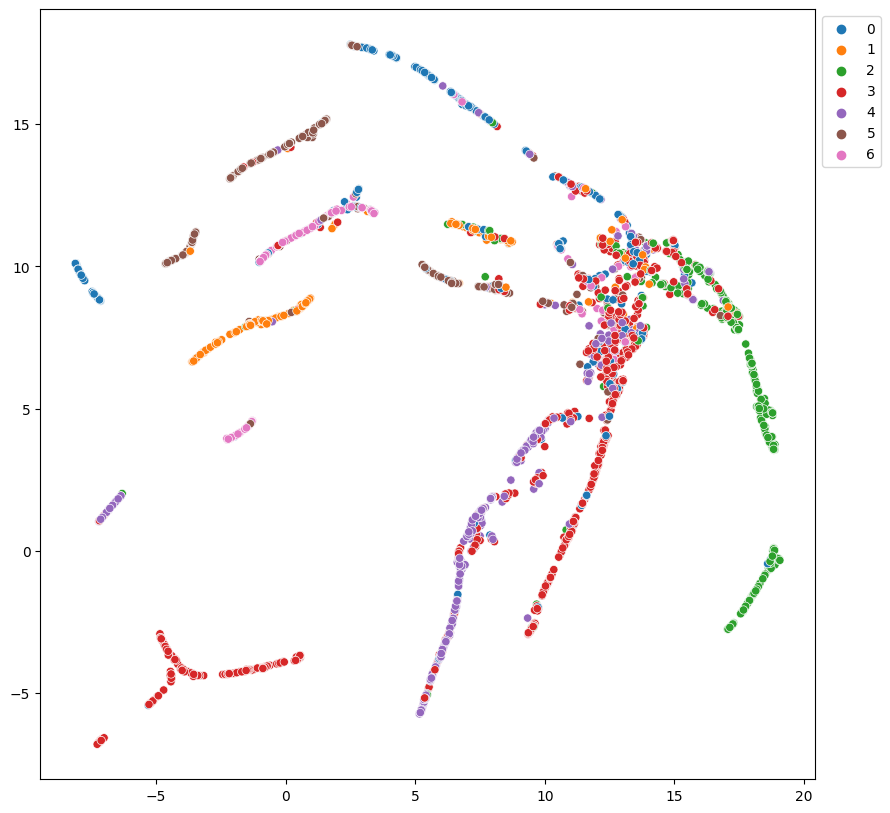

In [50]:
out_numpy = out.detach().cpu().numpy()
palette = {}

for n, y in enumerate(set(data.y.numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

In [49]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

predicted_labels = out.argmax(dim=1)

test_mask = data.test_mask
val_mask = data.val_mask

# Calculate test accuracy
correct_predictions = (predicted_labels[test_mask] == data.y[test_mask]).sum().item()
total_test_nodes = test_mask.sum().item()
test_accuracy = correct_predictions / total_test_nodes

# Calculate validation accuracy
val_mask = torch.tensor(val_mask, dtype=torch.bool)
correct_predictions_val = (predicted_labels[val_mask] == data.y[val_mask]).sum().item()
total_val_nodes = val_mask.sum().item()
val_accuracy = correct_predictions_val / total_val_nodes

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Test Accuracy: 68.00%
Validation Accuracy: 68.00%


<ipython-input-49-c475814dd3d5>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_mask = torch.tensor(val_mask, dtype=torch.bool)


In [47]:
from torch_geometric.nn import GCNConv

def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

class GCN2(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes):
        super(GCN2, self).__init__()
        self.gcn1 = GCNConv(in_feats, n_hidden)
        self.gcn2 = GCNConv(n_hidden, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc


gcn = GCN2(dataset.num_features, 16, dataset.num_classes)
print(gcn)
# Train
gcn.fit(data, epochs=200)
# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN2(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
  (relu): ReLU()
)
Epoch   0 | Train Loss: 1.955 | Train Acc: 10.71% | Val Loss: 1.97 | Val Acc: 7.20%
Epoch  20 | Train Loss: 0.172 | Train Acc: 100.00% | Val Loss: 0.89 | Val Acc: 74.80%
Epoch  40 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.79 | Val Acc: 77.00%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.00%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 76.80%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 76.80%
Epoch 120 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 76.60%
Epoch 140 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 76.60%
Epoch 160 | Train Loss: 0.012 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 76.40%
Epoch 180 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 76.40%
Epoch 200 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0